In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os

base_path = "/kaggle/input/utkface-new"

for folder in os.listdir(base_path):
    print(f"\nContents of '{folder}':")
    print(os.listdir(os.path.join(base_path, folder))[:5])



Contents of 'UTKFace':
['26_0_2_20170104023102422.jpg.chip.jpg', '22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg', '28_0_0_20170117180555824.jpg.chip.jpg', '17_1_4_20170103222931966.jpg.chip.jpg']

Contents of 'utkface_aligned_cropped':
['UTKFace', 'crop_part1']

Contents of 'crop_part1':
['26_0_2_20170104023102422.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg', '17_1_4_20170103222931966.jpg.chip.jpg', '76_0_0_20170104213515132.jpg.chip.jpg', '18_1_0_20170104022856102.jpg.chip.jpg']


100%|██████████| 23708/23708 [02:57<00:00, 133.69it/s]


X_age shape: (23686, 64, 64, 3)
y_age shape: (23686,)


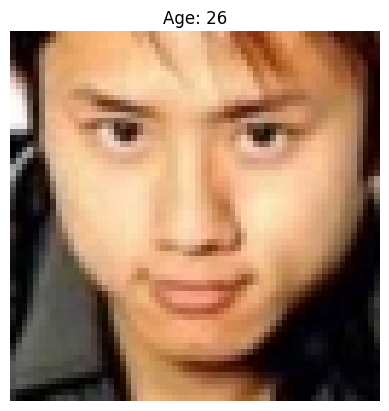

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Correct folder path
utkface_path = "/kaggle/input/utkface-new/UTKFace"
image_size = 64  # Resize to 64x64

X_age = []
y_age = []

for file in tqdm(os.listdir(utkface_path)):
    try:
        if not file.endswith(".jpg.chip.jpg"):
            continue
        age = int(file.split("_")[0])
        if age > 100:  # Skip unrealistic values
            continue
        img_path = os.path.join(utkface_path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (image_size, image_size))
        X_age.append(img)
        y_age.append(age)
    except Exception as e:
        pass

X_age = np.array(X_age)
y_age = np.array(y_age)

print("X_age shape:", X_age.shape)
print("y_age shape:", y_age.shape)

# Preview a sample image
plt.imshow(X_age[0])
plt.title(f"Age: {y_age[0]}")
plt.axis('off')
plt.show()


In [3]:
from sklearn.model_selection import train_test_split

# Normalize image data
X_age = X_age / 255.0

# Split data into 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_age, y_age, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape)
print("Validation samples:", X_val.shape)


Training samples: (18948, 64, 64, 3)
Validation samples: (4738, 64, 64, 3)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build the CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Output: single age value (regression)
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary
model.summary()


2025-06-26 10:09:23.783371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750932564.003843      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750932564.064590      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-26 10:09:39.458711: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 31, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 6, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,225 (2.61 MB)

 Trainable params: 683,777 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64
)


Epoch 1/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 268ms/step - loss: 264.3459 - mae: 11.9866 - val_loss: 1135.1508 - val_mae: 30.5534
Epoch 2/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 71s 239ms/step - loss: 116.2549 - mae: 8.1442 - val_loss: 147.3245 - val_mae: 9.4843
Epoch 3/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 71s 239ms/step - loss: 105.4556 - mae: 7.7785 - val_loss: 101.9746 - val_mae: 7.6322
Epoch 4/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 71s 240ms/step - loss: 82.1230 - mae: 6.8268 - val_loss: 92.3638 - val_mae: 7.1426
Epoch 5/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 70s 237ms/step - loss: 70.5045 - mae: 6.3275 - val_loss: 107.7222 - val_mae: 7.7458
Epoch 6/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 70s 237ms/step - loss: 73.5672 - mae: 6.4765 - val_loss: 138.8791 - val_mae: 9.1943
Epoch 7/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 71s 238ms/step - loss: 61.1172 - mae: 5.8995 - val_loss: 93.6742 - val_mae: 7.2811
Epoch 8/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 71s 239ms/step - loss: 52.6922 - mae: 5.4894 - val_loss: 78.6969 - val_mae: 6.4004
Epoch

In [6]:
model.save("age_predictor_model.h5")
print("done!")

done!
